# Image Analysis Workflow for BBBC007v1 Dataset

In this notebook, we will implement an image analysis workflow to process the BBBC007v1 dataset. Our goal is to segment the images, extract features from these segmented regions, and analyze the correlation between different features.

Citation: "We used image set BBBC007v1 image set version 1 (Jones et al., Proc. ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012]."


## Steps to be Followed in the Notebook

1. Import all necessary libraries.
2. Load images and corresponding label images.
3. Implement an image segmentation workflow.
4. Extract features from the segmented images.
5. Visualize relationships between extracted features.
6. Find correlations between the features.
7. Setup quality assurance procedures and measure the quality of segmentation.
8. Save segmentation results and extracted features.


### Installation Instructions

To run this notebook, you need to have several Python libraries installed. You can install the necessary libraries using pip or conda.

#### Using pip:
```
pip install numpy pandas matplotlib scikit-image scikit-learn seaborn stackview the-segmentation-game
```

#### Using conda:
```
conda install numpy pandas matplotlib scikit-image scikit-learn seaborn stackview
pip install the-segmentation-game
```


In [1]:
# Step 1: Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology, segmentation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from the_segmentation_game import metrics
import stackview


### Step 2: Load images and corresponding label images
Load the images and their corresponding label images from the provided directories.

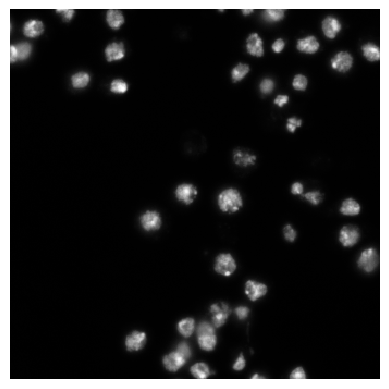

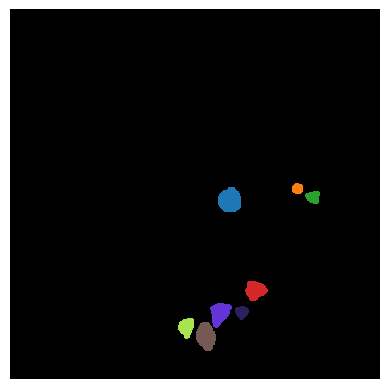

In [2]:
# Define directories
image_folder = '../05b_quality_assurance/data/BBBC007_batch/'
label_folder = '../05b_quality_assurance/data/BBBC007_sparse_instance_annotation/'

# Load images and labels
images = []
labels = []
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.tif')])

for file in image_files:
    image_path = os.path.join(image_folder, file)
    label_path = os.path.join(label_folder, file)
    images.append(io.imread(image_path))
    labels.append(io.imread(label_path))
    
# Display first image and its label as an example
stackview.imshow(images[0])
stackview.imshow(labels[0])

### Step 3: Implement an image segmentation workflow
Here, we will perform image segmentation using a basic thresholding method and morphological operations.

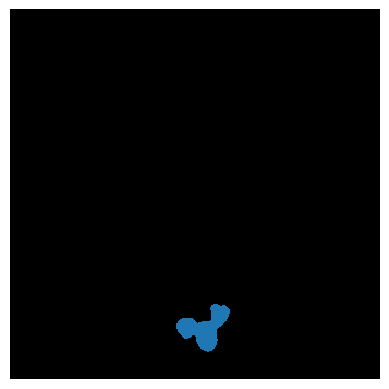

In [3]:
# Segmentation function using Otsu's thresholding
def segment_image(image):
    # Apply Gaussian filter for smoothing
    smooth_image = filters.gaussian(image, sigma=2.0)
    # Apply Otsu's thresholding
    threshold = filters.threshold_otsu(smooth_image)
    binary_image = smooth_image > threshold
    # Remove small objects and noise
    cleaned_image = morphology.remove_small_objects(binary_image, min_size=500)
    # Label the segmented regions
    label_image = measure.label(cleaned_image)
    return label_image

# Segment all images
segmented_labels = [segment_image(img) for img in images]

# Display first segmented image as an example
stackview.imshow(segmented_labels[0])

### Step 4: Extract features from the segmented images
We will extract features such as area, mean intensity, and solidity from the segmented regions.

In [4]:
# Feature extraction function
def extract_features(image, label_image):
    props = measure.regionprops(label_image, image)
    features = []
    for prop in props:
        features.append({
            'label': prop.label,
            'area': prop.area,
            'mean_intensity': prop.mean_intensity,
            'solidity': prop.solidity
        })
    return features

# Extract features for all images
all_features = []
for img, lbl in zip(images, segmented_labels):
    features = extract_features(img, lbl)
    all_features.extend(features)

# Convert to DataFrame
features_df = pd.DataFrame(all_features)
display(features_df.head())

,label,area,mean_intensity,solidity
0,1,1025.0,88.807805,0.748175
1,1,838.0,98.363962,0.857728
2,2,798.0,98.582707,0.795613
3,1,538.0,93.994424,0.898164
4,2,634.0,82.493691,0.892958


### Step 5: Visualize relationships between extracted features
We will use pair plots to visualize the relationships between different extracted features.

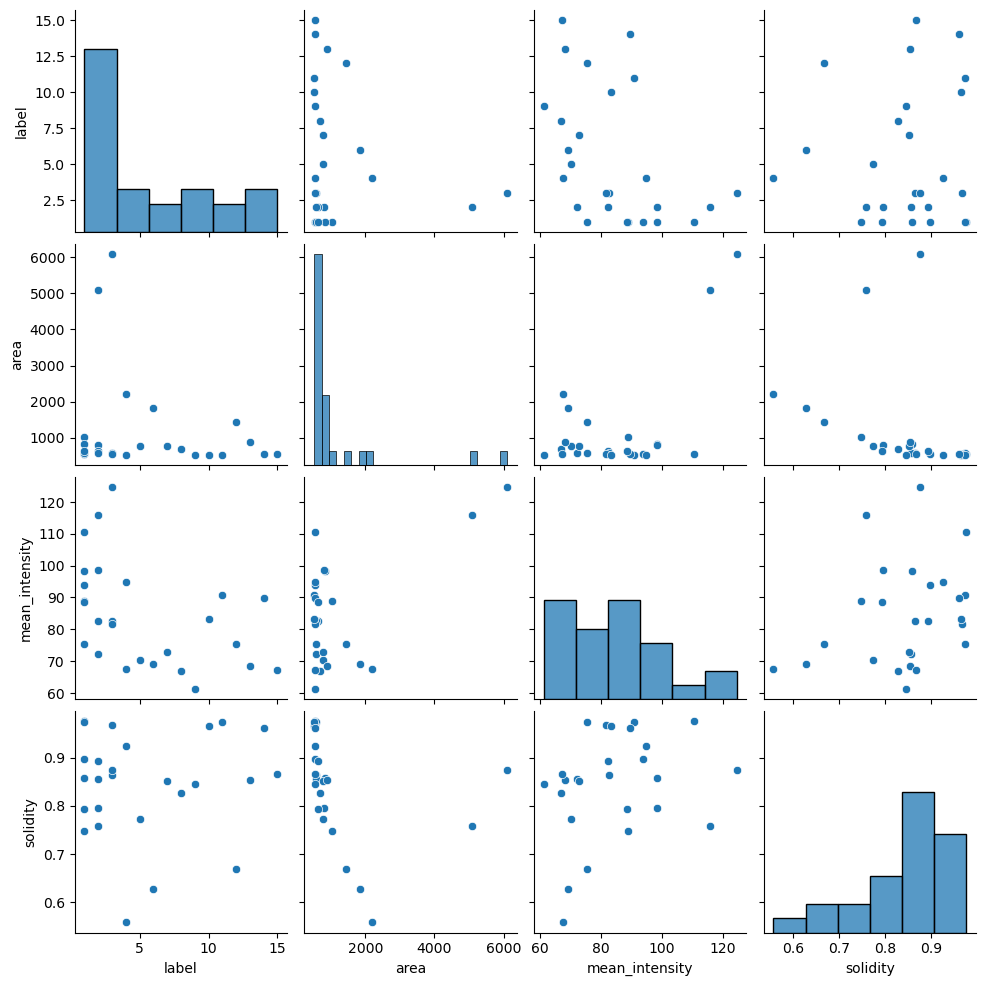

In [5]:
# Pair plot for visualizing feature relationships
sns.pairplot(features_df)
plt.show()

### Step 6: Find correlations between the features
Compute the Pearson correlation coefficients between each pair of features.

,label,area,mean_intensity,solidity
label,1.000000,-0.171732,-0.441422,0.047468
area,-0.171732,1.000000,0.553719,-0.321489
mean_intensity,-0.441422,0.553719,1.000000,0.273426
solidity,0.047468,-0.321489,0.273426,1.000000


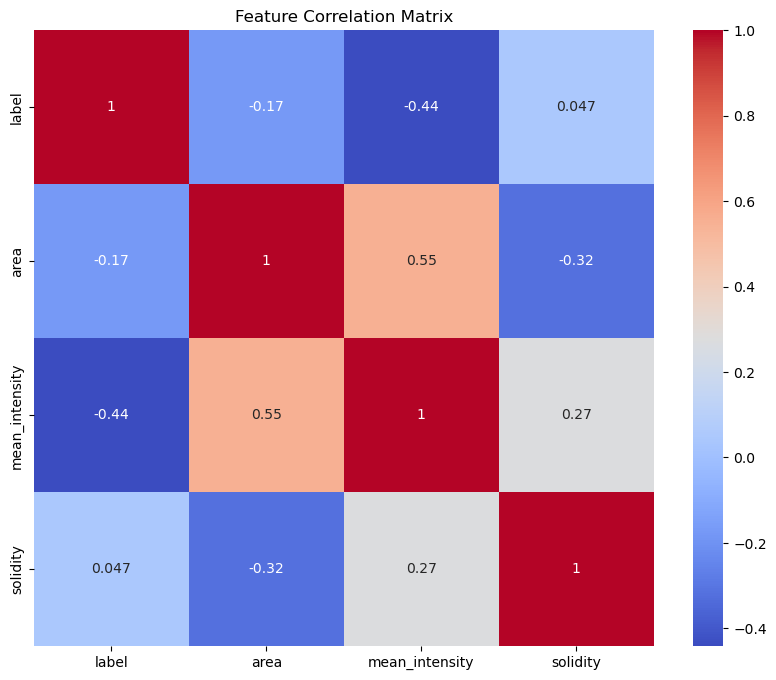

In [6]:
# Compute correlation matrix
correlation_matrix = features_df.corr()
display(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### Step 7: Setup quality assurance procedures and measure the quality of segmentation
We will use the sparse Jaccard index to measure the segmentation quality against the provided label images.

,Image,Jaccard_Index
0,17P1_POS0013_D_1UL.tif,0.099350
1,20P1_POS0005_D_1UL.tif,0.148671
2,20P1_POS0007_D_1UL.tif,0.000000
3,20P1_POS0010_D_1UL.tif,0.000000
4,A9 p7d.tif,0.212829
5,AS_09125_040701150004_A02f00d0.tif,0.017902


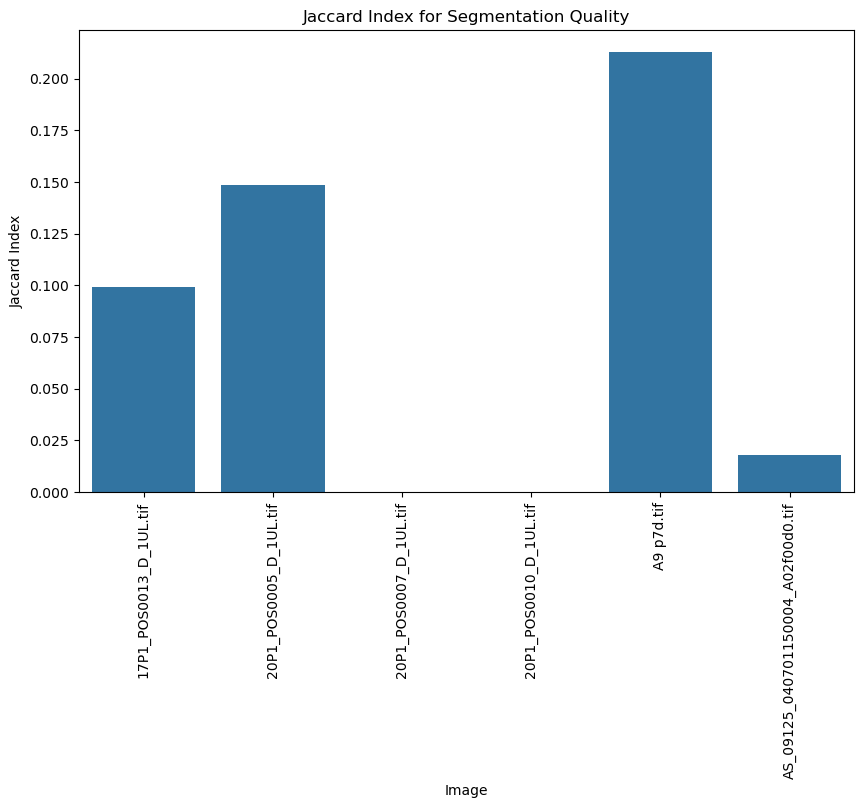

In [7]:
# Compute Jaccard index for each pair of label and segmented image
jaccard_indices = []
for lbl, seg_lbl in zip(labels, segmented_labels):
    jaccard = metrics.jaccard_index_sparse(lbl, seg_lbl)
    jaccard_indices.append(jaccard)

# Convert to DataFrame
jaccard_df = pd.DataFrame({'Image': image_files, 'Jaccard_Index': jaccard_indices})
display(jaccard_df)

# Plot Jaccard indices
plt.figure(figsize=(10, 6))
sns.barplot(x='Image', y='Jaccard_Index', data=jaccard_df)
plt.xticks(rotation=90)
plt.xlabel('Image')
plt.ylabel('Jaccard Index')
plt.title('Jaccard Index for Segmentation Quality')
plt.show()

### Step 8: Save segmentation results and extracted features
Finally, we will save the segmentation results and extracted features to disk as label images and CSV files respectively.

In [8]:
# Save segmented label images
segmentation_output_folder = './segmentation_results/'
os.makedirs(segmentation_output_folder, exist_ok=True)

for i, seg_label in enumerate(segmented_labels):
    io.imsave(os.path.join(segmentation_output_folder, image_files[i]), seg_label)

# Save extracted features
features_df.to_csv('extracted_features.csv', index=False)

C:\Users\haase\AppData\Local\Temp\ipykernel_25104\1617834175.py:6: UserWarning: ./segmentation_results/17P1_POS0013_D_1UL.tif is a low contrast image
  io.imsave(os.path.join(segmentation_output_folder, image_files[i]), seg_label)
C:\Users\haase\AppData\Local\Temp\ipykernel_25104\1617834175.py:6: UserWarning: ./segmentation_results/20P1_POS0005_D_1UL.tif is a low contrast image
  io.imsave(os.path.join(segmentation_output_folder, image_files[i]), seg_label)
C:\Users\haase\AppData\Local\Temp\ipykernel_25104\1617834175.py:6: UserWarning: ./segmentation_results/20P1_POS0007_D_1UL.tif is a low contrast image
  io.imsave(os.path.join(segmentation_output_folder, image_files[i]), seg_label)
C:\Users\haase\AppData\Local\Temp\ipykernel_25104\1617834175.py:6: UserWarning: ./segmentation_results/20P1_POS0010_D_1UL.tif is a low contrast image
  io.imsave(os.path.join(segmentation_output_folder, image_files[i]), seg_label)
C:\Users\haase\AppData\Local\Temp\ipykernel_25104\1617834175.py:6: UserWarni